<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.4.SARIMAX_VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SARIMAX

본 실습에서는 SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) 모델을 활용하여 1959년부터 2009년까지 분기별로 수집된 미국의 거시경제 데이터 집합을 사용하여 미국의 실질 GDP를 예측해보도록 하겠습니다.

참고: https://github.com/jpub-dongdong9/TimeSeriesForecastingInPython/blob/master/CH09/CH09.ipynb


---


The $SARIMAX(p,d,q)(P,D,Q)_m$ model is represented as:

$$
\Delta^d \Delta_m^D y_t = \mu + \sum_{i=1}^{p} \phi_i y_{t-i} + \sum_{i=1}^{q} \theta_i \epsilon_{t-i} + \sum_{i=1}^{P} \Phi_i y_{t-im} + \sum_{i=1}^{Q} \Theta_i \epsilon_{t-im} + X_t \beta + \epsilon_t
$$

Where:

<ul>
  <li><strong>\( y_t \)</strong>: the dependent variable at time \( t \)</li>
  <li><strong>\( \mu \)</strong>: constant term</li>
  <li><strong>\( \Delta^d \)</strong>: non-seasonal differencing of order \( d \)</li>
  <li><strong>\( \Delta_m^D \)</strong>: seasonal differencing of order \( D \) with seasonality period \( m \)</li>
  <li><strong>\( \phi_1, \dots, \phi_p \)</strong>: coefficients of the non-seasonal AR terms</li>
  <li><strong>\( \theta_1, \dots, \theta_q \)</strong>: coefficients of the non-seasonal MA terms</li>
  <li><strong>\( \Phi_1, \dots, \Phi_P \)</strong>: coefficients of the seasonal AR terms</li>
  <li><strong>\( \Theta_1, \dots, \Theta_Q \)</strong>: coefficients of the seasonal MA terms</li>
  <li><strong>\( m \)</strong>: the number of periods in a season</li>
  <li><strong>\( X_t \)</strong>: exogenous variables at time \( t \)</li>
  <li><strong>\( \beta \)</strong>: coefficients of the exogenous variables</li>
  <li><strong>\( \epsilon_t \)</strong>: white noise or error term</li>
</ul>

In [ ]:
!pip install pmdarima

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union, List, Iterable

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# 미국 거시경제 데이터 집합 로딩
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


### 변수 설명

<table>
  <tr>
    <th>변수</th>
    <th>설명</th>
  </tr>
  <tr>
    <td><strong>year</strong></td>
    <td>연도 (해당 데이터가 수집된 연도)</td>
  </tr>
  <tr>
    <td><strong>quarter</strong></td>
    <td>분기 (1년 중 4분기로 나눈 시기)</td>
  </tr>
  <tr>
    <td><strong>realgdp</strong></td>
    <td>실질 GDP (물가 변동을 제외한 국내총생산) / <strong>목표변수</strong></td>
  </tr>
  <tr>
    <td><strong>realcons</strong></td>
    <td>실질 소비 (물가 변동을 제외한 가계 소비 지출)</td>
  </tr>
  <tr>
    <td><strong>realinv</strong></td>
    <td>실질 투자 (물가 변동을 제외한 투자 지출)</td>
  </tr>
  <tr>
    <td><strong>realgovt</strong></td>
    <td>실질 정부 지출 (물가 변동을 제외한 정부 소비 지출)</td>
  </tr>
  <tr>
    <td><strong>realdpi</strong></td>
    <td>실질 DPI (물가 변동을 제외한 가처분소득)</td>
  </tr>
  <tr>
    <td><strong>cpi</strong></td>
    <td>소비자 물가 지수 (소비자 물가의 변동을 측정)</td>
  </tr>
  <tr>
    <td><strong>m1</strong></td>
    <td>통화량 (유통되는 화폐 및 은행 예금 포함)</td>
  </tr>
  <tr>
    <td><strong>tbilrate</strong></td>
    <td>단기 국채 금리 (3개월짜리 미국 국채의 금리)</td>
  </tr>
  <tr>
    <td><strong>unemp</strong></td>
    <td>실업률 (경제활동 인구 중 실업자의 비율)</td>
  </tr>
  <tr>
    <td><strong>pop</strong></td>
    <td>인구 (전체 인구 수)</td>
  </tr>
  <tr>
    <td><strong>infl</strong></td>
    <td>인플레이션 (물가 상승률)</td>
  </tr>
  <tr>
    <td><strong>realint</strong></td>
    <td>실질 이자율 (명목 이자율에서 인플레이션을 제외한 이자율)</td>
  </tr>
</table>


Target Variable인 GDP의 개형 확인

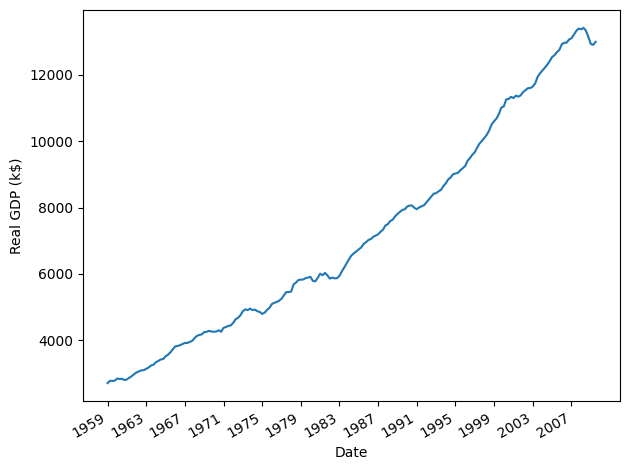

In [ ]:
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()



---



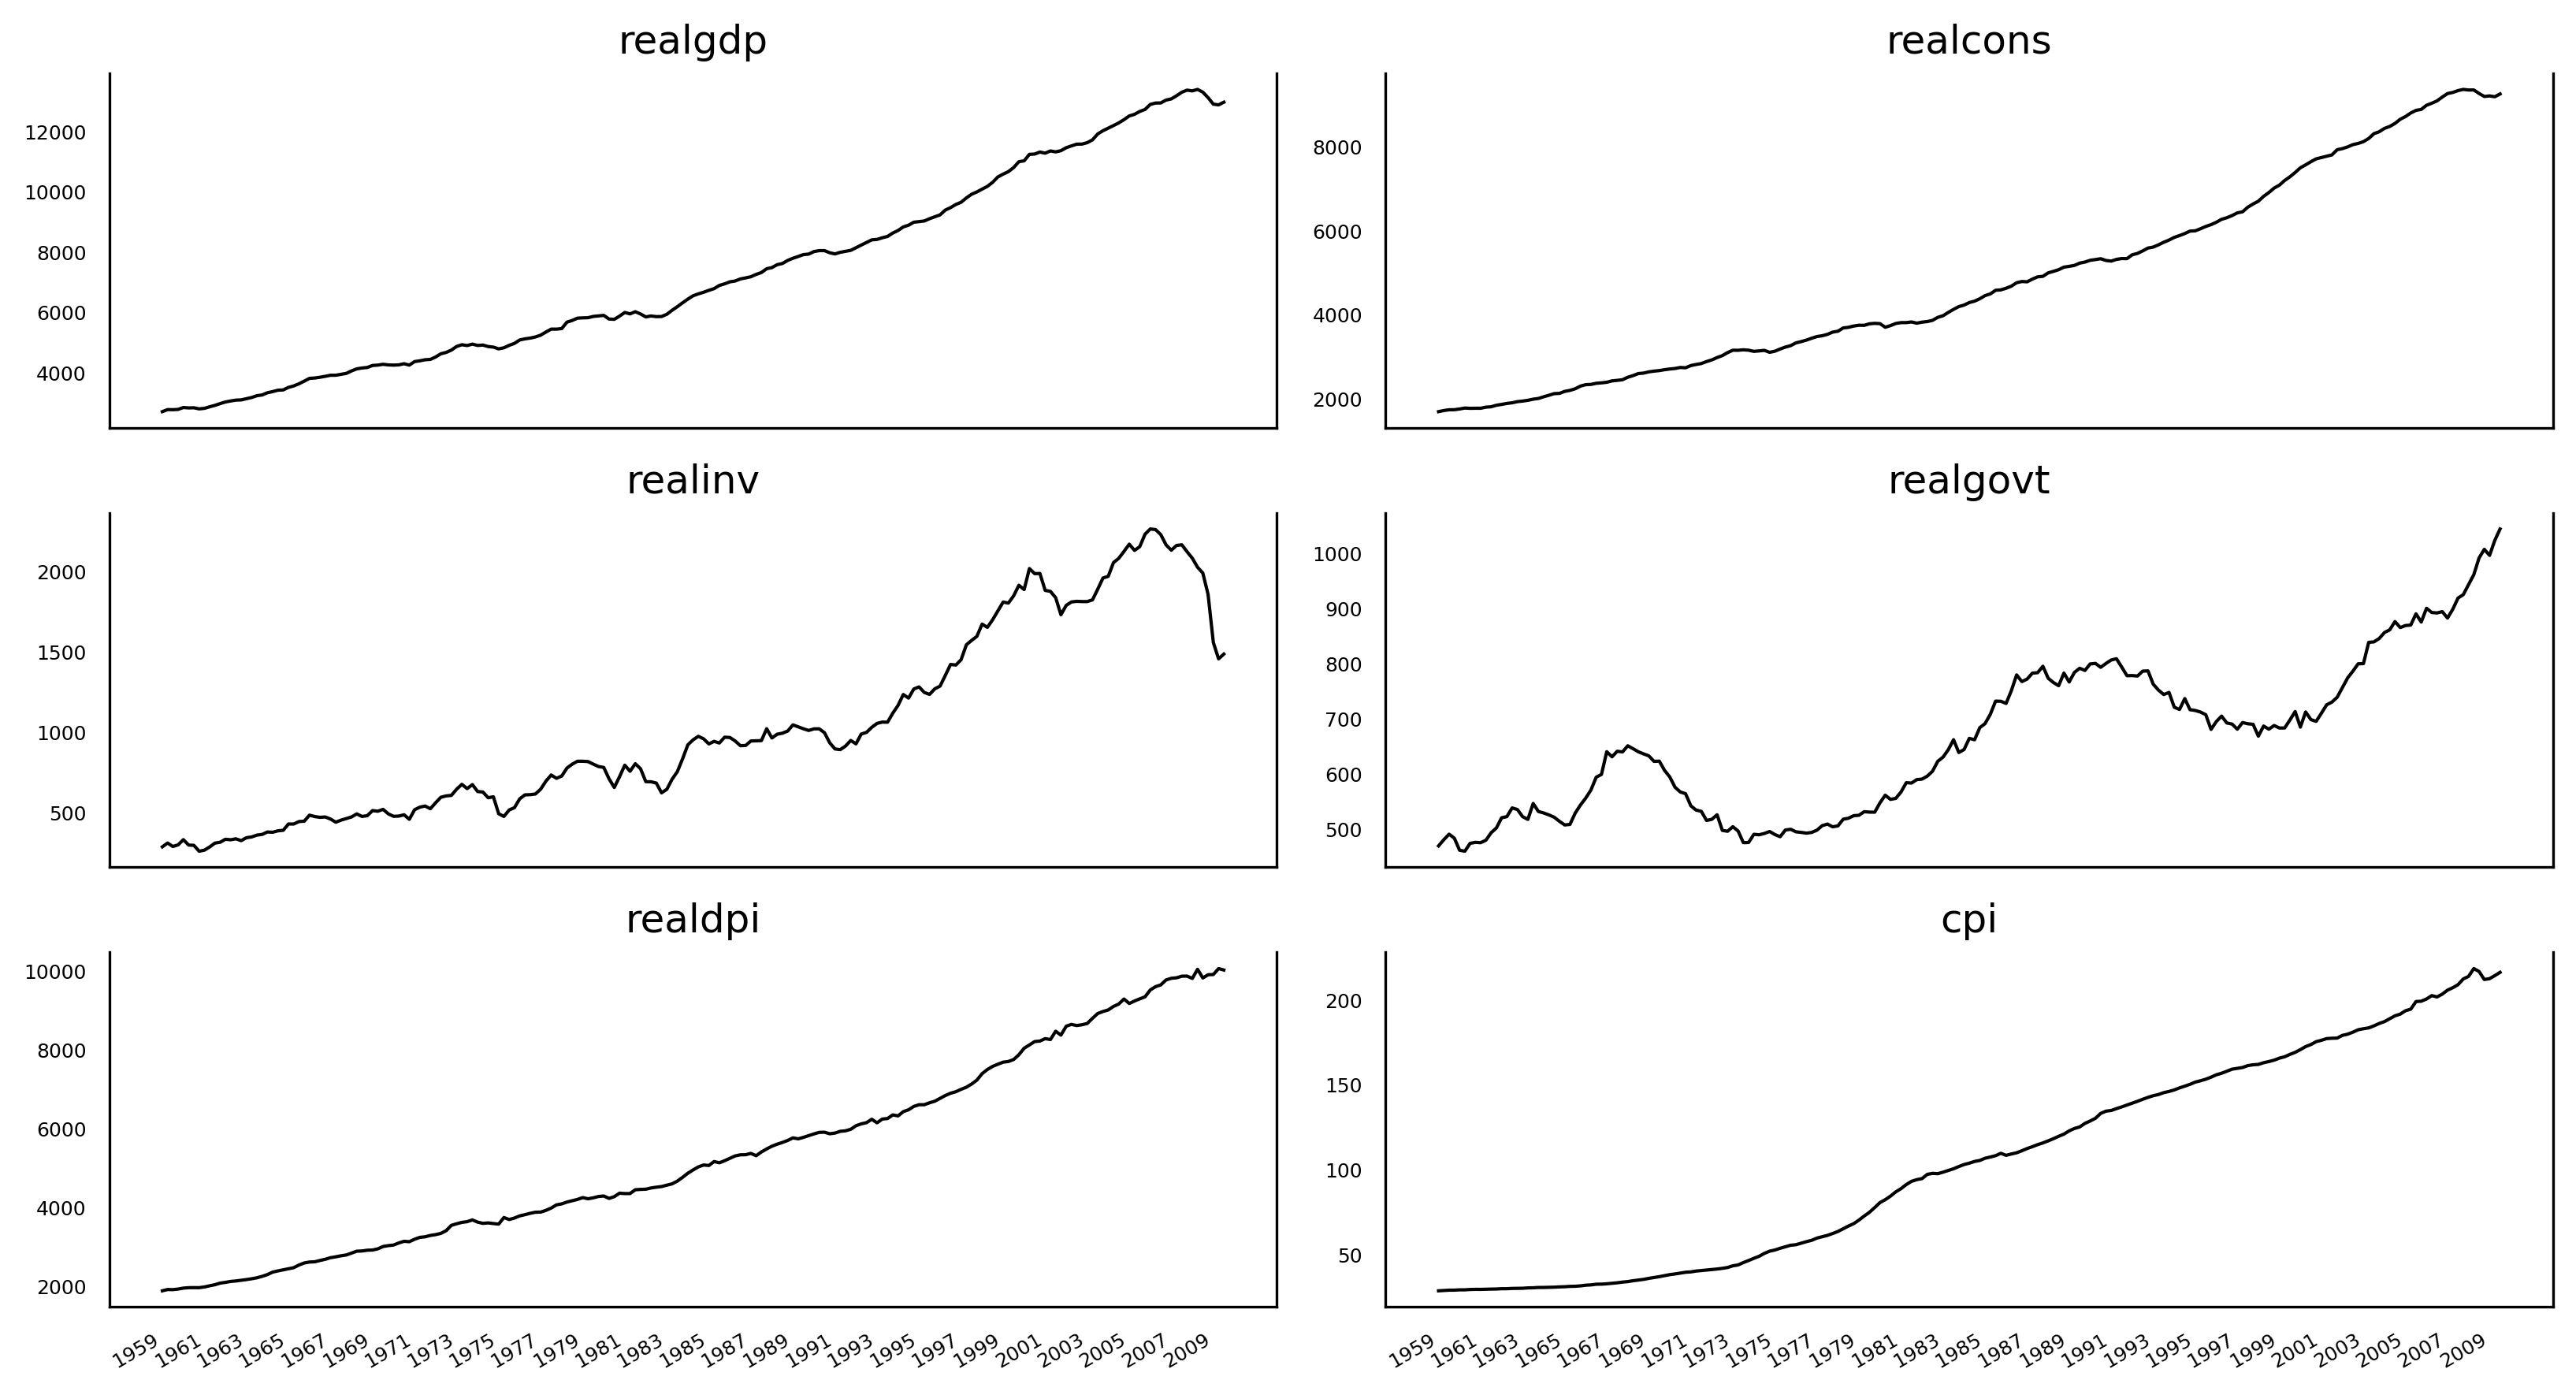

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

# 6개 변수에 대한 개형 확인
for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

### 외생변수 / 내생변수 설정

In [ ]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

### ADF 테스트를 사용하여 정상성 확인

In [ ]:
def run_adf_test(series: pd.Series) -> None:
    """
    Augmented Dickey-Fuller (ADF) 테스트를 실행하고 결과를 출력하는 함수입니다.

    매개변수:
        series (pd.Series): ADF 테스트를 수행할 시계열 데이터 (Pandas Series 형식).

    반환값:
        None: 출력만 수행하며 별도의 반환값은 없습니다.

    동작:
        - ADF 통계량, p-value, 임계값을 출력합니다.
        - p-value에 따라 시계열이 정상적인지 여부를 출력합니다.
        - p-value < 0.05일 경우 귀무 가설(H0)을 기각하여 정상성을 가지는 것으로 간주합니다.
    """
    result = adfuller(series)

    # Bold formatting with ANSI codes
    bold_start = '\033[1m'
    bold_end = '\033[0m'

    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')

    # p-value에 따른 해석 출력
    if result[1] < 0.05:
        print(f'-> Input series is {bold_start}stationary (reject H0).{bold_end}')
    else:
        print(f'-> Input series is {bold_start}non-stationary (fail to reject H0).{bold_end}')

In [ ]:
run_adf_test(target)

ADF Statistic: 1.7504627967647144
p-value: 0.9982455372335032
Critical Values:
   1%: -3.4652
   5%: -2.8769
   10%: -2.5749
-> Input series is non-stationary (fail to reject H0).


In [ ]:
target_diff = target.diff()

run_adf_test(target_diff[1:])

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
-> Input series is stationary (reject H0).


$d=1$로 설정하면 시계열을 정상적 상태로 만들 수 있다.

### SARIMAX 모델 찾기

In [ ]:
def optimize_SARIMAX(endog: Union[pd.Series, List], exog: Union[pd.Series, List], order_list: List, d: int, D: int, s: int) -> pd.DataFrame:
    """
    주어진 파라미터 목록에 대해 SARIMAX 모델을 최적화하고 AIC 값에 따라 결과를 반환하는 함수입니다.

    매개변수:
        endog (pd.Series 또는 List): 종속 변수, 시계열 데이터.
        exog (pd.Series 또는 List): 외생 변수(있을 경우), 시계열 데이터.
        order_list (List): SARIMA 모델의 (p, q, P, Q) 조합을 포함한 리스트.
        d (int): 비계절 차분의 차수.
        D (int): 계절 차분의 차수.
        s (int): 계절 주기 (예: 12는 월별 데이터를 의미).

    반환값:
        pd.DataFrame: (p, q, P, Q) 조합과 해당 SARIMAX 모델의 AIC 값을 포함한 데이터프레임.
                      AIC 값이 낮을수록 더 나은 모델이며, AIC 기준으로 오름차순으로 정렬됩니다.

    동작:
        - 주어진 (p, q, P, Q) 조합과 차분 차수를 사용하여 SARIMAX 모델을 적합시킵니다.
        - 각 모델의 AIC 값을 계산한 후 결과 리스트에 저장합니다.
        - AIC 값을 기준으로 오름차순으로 정렬된 결과를 데이터프레임 형식으로 반환합니다.

    예외 처리:
        - 모델 적합 과정에서 오류가 발생하면 해당 조합을 건너뜁니다.
    """
    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # 오름차순으로 정렬 (AIC 낮을수록 좋음)
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

### 함수 피팅
피팅을 위해 처음 200개 데이터 사용

In [ ]:
target_train = target[:200]
exog_train = exog[:200]

In [ ]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.824297
1,"(3, 3, 1, 0)",1744.966208
2,"(3, 3, 0, 1)",1744.996576
3,"(2, 2, 0, 0)",1745.449024
4,"(2, 2, 0, 1)",1746.323743
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


### auto arima 활용

In [ ]:
model = pm.auto_arima(
    y = target_train,
    X = exog_train,
    start_p = p[0],
    d = d,
    start_q = q[0],
    max_p = p[-1],
    max_q = q[-1],
    start_P = P[0],
    D = D,
    start_Q = Q[0],
    max_P = P[-1],
    max_Q = Q[-1],
    m = s,
    trace = True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=1763.242, Time=0.38 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=1758.394, Time=1.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=1758.799, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=1764.755, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=1764.799, Time=0.34 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=1760.302, Time=1.37 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=1760.385, Time=1.15 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=1758.759, Time=0.99 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=1760.119, Time=1.67 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=1756.518, Time=0.87 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=1758.420, Time=1.18 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=1758.482, Time=4.60 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=1756.923, Time=0.82 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=1758.139, Time=1.26 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Sun, 08 Sep 2024   AIC                           1742.824
Time:                        09:31:49   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.505      0.000       0.882       1.059
realinv        1.0132      0.033     30.693      0.000       0.948       1.078
realgovt       0.7283      0.127      5.728      0.0

### Best model 분석

In [ ]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.412
Date:                Sun, 08 Sep 2024   AIC                           1742.824
Time:                        09:31:50   BIC                           1782.344
Sample:                             0   HQIC                          1758.819
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9708      0.045     21.505      0.000       0.882       1.059
realinv        1.0132      0.033     30.693      0.000       0.948       1.078
realgovt       0.7283      0.127      5.728      0.0

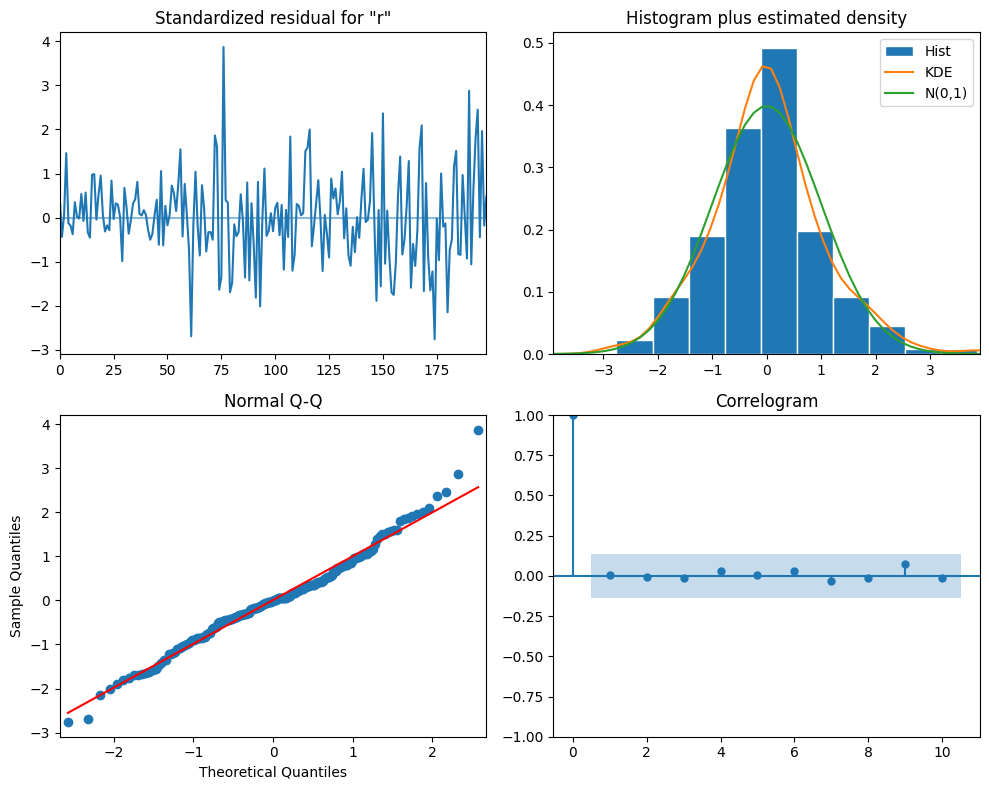

In [ ]:
best_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.show()

#### 시각화 결과 해석 방식

1. **Standardized Residuals Plot**: 표준화 잔차 그래프 (좌상단)
  * 설명: 이 그래프는 잔차(실제 값과 예측 값의 차이)를 표준화한 후 시간에 따라 보여줍니다.
  * 해석: 잔차는 0을 중심으로 무작위로 분포해야 합니다. 패턴이 보이면 모델이 데이터를 충분히 설명하지 못한 것입니다.
2. **Histogram and KDE of Residuals**: 잔차의 히스토그램과 KDE (우상단)
  * 설명: 잔차의 분포를 히스토그램으로 보여주고, 그 위에 커널 밀도 추정(KDE) 곡선을 겹쳐서 나타냅니다.
  * 해석: 잔차가 정규 분포를 따라야 합니다. 정규 분포에서 벗어난다면, 모델이 데이터의 변동성을 충분히 설명하지 못했을 수 있습니다.
3. **Q-Q Plot**: Q-Q 플롯 (좌하단)
  * 설명: 잔차의 분포를 이론적인 정규 분포와 비교하는 그래프입니다.
  * 해석: 점들이 대각선에 가까울수록 잔차가 정규 분포에 가깝습니다. 점들이 선에서 크게 벗어나면, 잔차가 정규 분포를 따르지 않는 것입니다.
4. **Correlogram of Residuals (ACF Plot)** 잔차의 ACF 플롯 (우하단)
  * 설명: 잔차의 자기상관(autocorrelation)을 나타낸 그래프입니다. 잔차가 서로 다른 시점에서 얼마나 관련 있는지를 보여줍니다.
  * 해석: 그래프에 있는 막대가 파란 선을 넘지 않아야 합니다. 만약 넘는다면, 모델이 데이터를 충분히 설명하지 못하고 시계열 패턴이 남아 있다는 의미입니다.



> **좋은 모델이란 잔차가 0을 중심으로 무작위로 분포하고, 정규 분포를 따르며, ACF 그래프에서 큰 자기상관이 없는 모델.**


### 잔차의 상관관계 분석 (융-박스 테스트 활용)
귀무가설은 잔차가 독립적이고 상관관계가 없다는 것.

In [ ]:
residuals = best_model_fit.resid

acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.092071,0.761560
2,0.198871,0.905348
3,0.200938,0.977438
4,1.257216,0.868591
5,1.258003,0.939193
6,1.285134,0.972471
7,1.476883,0.983099
8,1.486838,0.992924
9,1.859312,0.993502
10,1.866005,0.997268


### 모델 활용한 예측 수행

In [ ]:
def rolling_forecast(endog: Union[pd.Series, List], exog: Union[pd.Series, List], train_len: int, horizon: int, window: int, method: str) -> List:
    """
    주어진 시계열 데이터에 대해 롤링 방식으로 예측을 수행하는 함수입니다.

    매개변수:
        endog (pd.Series 또는 List): 종속 변수, 예측 대상 시계열 데이터.
        exog (pd.Series 또는 List): 외생 변수, 예측에 사용할 외부 변수.
        train_len (int): 초기 학습 데이터의 길이.
        horizon (int): 예측을 위한 총 길이 (학습 데이터 이후 예측할 기간).
        window (int): 예측할 구간의 크기. 한 번에 예측할 기간의 길이.
        method (str): 예측 방법 ('last' 또는 'SARIMAX'). 'last'는 마지막 관측치를 사용한 예측, 'SARIMAX'는 SARIMAX 모델을 사용한 예측.

    반환값:
        List: 예측된 값들의 리스트.

    동작:
        - 'last' 방법: 각 롤링 구간에서 마지막 관측치를 사용하여 향후 값을 예측합니다.
        - 'SARIMAX' 방법: 각 롤링 구간에서 SARIMAX 모델을 적합시키고 예측을 수행합니다.

    예외 처리:
        - 잘못된 예측 방법이 입력되면 에러 없이 종료됩니다.
    """

    # 학습 데이터와 예측 구간을 더한 총 길이 계산
    total_len = train_len + horizon

    # 'last' 방법을 사용한 예측
    if method == 'last':
        pred_last_value = []

        # 윈도우 크기만큼 롤링하여 마지막 값을 반복하여 예측
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]  # 현재 학습 데이터에서 마지막 값을 가져옴
            pred_last_value.extend(last_value for _ in range(window))  # 마지막 값을 윈도우 크기만큼 예측 값에 추가

        return pred_last_value

    # 'SARIMAX' 방법을 사용한 예측
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        # 윈도우 크기만큼 롤링하여 SARIMAX 모델을 적합시키고 예측
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)  # SARIMAX 모델 적합
            predictions = res.get_prediction(exog=exog)  # 외생 변수를 포함한 예측
            oos_pred = predictions.predicted_mean.iloc[-window:]  # 윈도우 크기만큼의 예측 값 추출
            pred_SARIMAX.extend(oos_pred)  # 예측 값을 리스트에 추가

        return pred_SARIMAX

In [ ]:
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.063231
197,13415.266,13366.865,13373.510608
198,13324.600,13415.266,13378.824552
199,13141.920,13324.600,13327.772094
200,12925.410,13141.920,13133.236577
201,12901.504,12925.410,12887.105293
202,12990.341,12901.504,12873.794486


### MAPE 활용한 모델 성능 평가

In [ ]:
def mape(y_true: Iterable[float], y_pred: Iterable[float]) -> float:
    """
    평균 절대 퍼센트 오차(MAPE)를 계산하는 함수입니다.

    매개변수:
        y_true (Iterable[float]): 실제 값의 배열, Pandas 시리즈 등 반복 가능한 객체.
        y_pred (Iterable[float]): 예측 값의 배열, Pandas 시리즈 등 반복 가능한 객체.

    반환값:
        float: 예측의 평균 절대 퍼센트 오차(MAPE).

    동작:
        - MAPE는 예측 값과 실제 값 간의 차이의 절대값을 백분율로 변환하여 평균을 구합니다.
        - 공식: MAPE = (1/n) * Σ |(y_true - y_pred) / y_true| * 100

    예외 처리:
        - 실제 값이 0일 경우, ZeroDivisionError가 발생할 수 있습니다.
        - 이를 방지하려면 데이터 전처리 과정에서 이러한 경우를 처리해야 합니다.
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7028079013951719


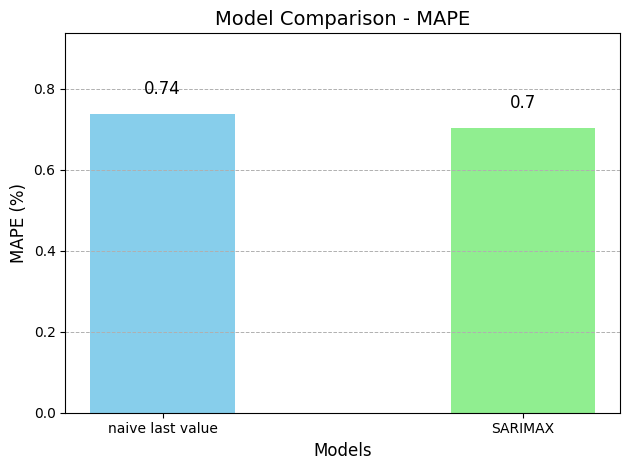

In [ ]:
fig, ax = plt.subplots()

# 데이터
x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

# 막대 그래프 생성
ax.bar(x, y, width=0.4, color=['skyblue', 'lightgreen'])

# 라벨과 제목 추가
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.set_title('Model Comparison - MAPE', fontsize=14)

# y축에 그리드라인 추가
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

# y축 범위 설정
ax.set_ylim(0, max(y) + 0.2)

# 막대 위에 값 라벨 추가
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value, 2)), ha='center', fontsize=12)

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

# VAR and Granger Causality

이번에서는 앞선 실습과 동일한 데이터를 활용하여 VAR (Vector Autoregression. 벡터자기회귀) 모델에 대한 실습을 진행하겠습니다.    
참고: https://github.com/jpub-dongdong9/TimeSeriesForecastingInPython/blob/master/CH10/CH10.ipynb



---

$n$ 차원 벡터에 대한 VAR$(p)$ 모형은 아래와 같이 표현됩니다:

$$
\mathbf{Y}_t = \mathbf{A}_1 \mathbf{Y}_{t-1} + \mathbf{A}_2 \mathbf{Y}_{t-2} + \dots + \mathbf{A}_p \mathbf{Y}_{t-p} + \mathbf{C} + \mathbf{\epsilon}_t
$$

Where:
<ul>
  <li><strong>\( \mathbf{Y}_t \)</strong>: \(n \times 1\) 크기의 시계열 변수 벡터 (시간 \(t\)에서의 종속 변수들)</li>
  <li><strong>\( \mathbf{A}_i \)</strong>: \(n \times n\) 크기의 계수 행렬</li>
  <li><strong>\( \mathbf{C} \)</strong>: \(n \times 1\) 크기의 상수 벡터</li>
  <li><strong>\( \mathbf{\epsilon}_t \)</strong>: \(n \times 1\) 크기의 오차 항 벡터</li>
</ul>




이를 풀어서 써보게 되면 아래와 같은 표현도 가능합니다.

$$
\begin{aligned}
Y_{1,t} &= c_1 + a_{11,1} Y_{1,t-1} + a_{12,1} Y_{2,t-1} + \dots + a_{1n,1} Y_{n,t-1} \\
        &\quad + a_{11,2} Y_{1,t-2} + a_{12,2} Y_{2,t-2} + \dots + a_{1n,p} Y_{n,t-p} + \epsilon_{1,t} \\
Y_{2,t} &= c_2 + a_{21,1} Y_{1,t-1} + a_{22,1} Y_{2,t-1} + \dots + a_{2n,1} Y_{n,t-1} \\
        &\quad + a_{21,2} Y_{1,t-2} + a_{22,2} Y_{2,t-2} + \dots + a_{2n,p} Y_{n,t-p} + \epsilon_{2,t} \\
&\vdots \\
Y_{n,t} &= c_n + a_{n1,1} Y_{1,t-1} + a_{n2,1} Y_{2,t-1} + \dots + a_{nn,1} Y_{n,t-1} \\
        &\quad + a_{n1,2} Y_{1,t-2} + a_{n2,2} Y_{2,t-2} + \dots + a_{nn,p} Y_{n,t-p} + \epsilon_{n,t}
\end{aligned}
$$

<ul>
  <li><strong>\(Y_{i,t}\)</strong>: 시간 \(t\)에서의 \(i\)번째 시계열 변수</li>
  <li><strong>\(c_i\)</strong>: \(i\)번째 변수의 상수 항</li>
  <li><strong>\(a_{ij,k}\)</strong>: 시차 \(k\)에서의 \(i\)번째 변수에 대한 \(j\)번째 변수의 계수</li>
  <li><strong>\(\epsilon_{i,t}\)</strong>: 시간 \(t\)에서의 \(i\)번째 변수의 오차 항</li>
</ul>


### 변수 설명    
이번에는 실질 소비 (**realcons**)와 실질 가처분 소득(**realdpi**) 사이의 관계를 살펴보도록 하겠습니다.     
실질 소비는 사람들이 얼마나 많은 돈을 소비하는지를 나타내며, 실질 가처분 소득은 얼마나 많은 돈을 쓸 수 있는지를 나타냅니다.    
따라서 가처분 소득이 많을수록 소비가 많다는 것은 합리적인 가설입니다. 반대로 소비가 많다는 것은 더 많은 소득을 소비할 수 있다는 것을 뜻하며, 그 반대의 논리도 가능합니다.

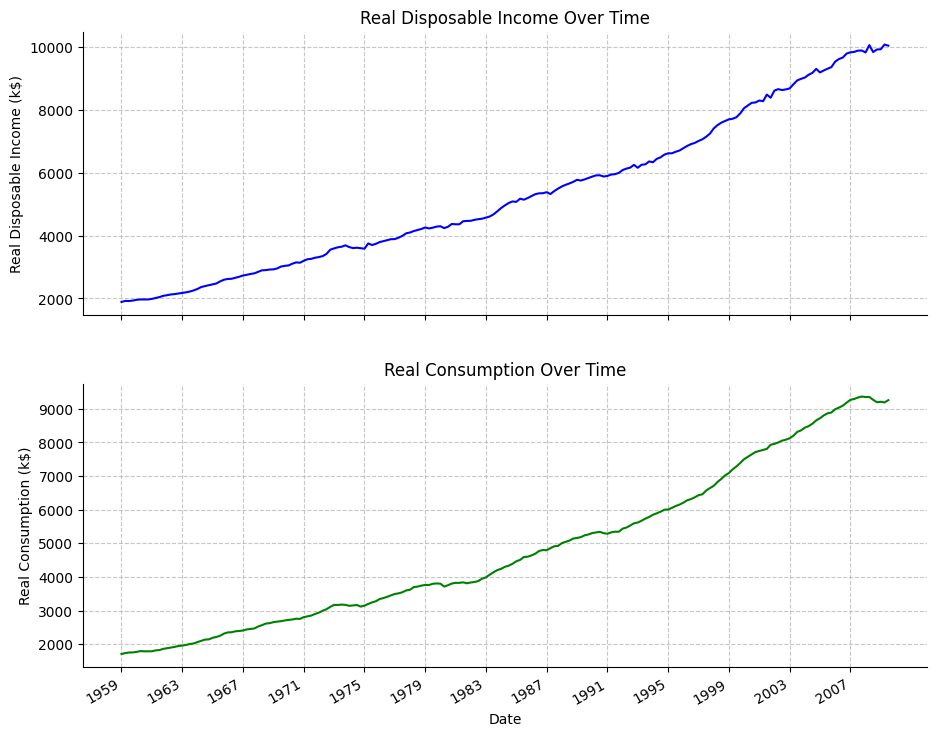

In [ ]:
# x축을 공유하는 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

# realdpi 그래프 (ax1)
ax1.plot(macro_econ_data['realdpi'], color='b')
ax1.set_ylabel('Real Disposable Income (k$)')
ax1.set_title('Real Disposable Income Over Time')
ax1.spines['top'].set_alpha(0)  # 상단 테두리 제거
ax1.spines['right'].set_alpha(0)  # 오른쪽 테두리 제거
ax1.grid(True, linestyle='--', alpha=0.7)  # 격자선 추가

# realcons 그래프 (ax2)
ax2.plot(macro_econ_data['realcons'], color='g')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real Consumption (k$)')
ax2.set_title('Real Consumption Over Time')
ax2.spines['top'].set_alpha(0)  # 상단 테두리 제거
ax2.spines['right'].set_alpha(0)  # 오른쪽 테두리 제거
ax2.grid(True, linestyle='--', alpha=0.7)  # 격자선 추가

# x축 눈금 설정 (공유된 x축)
ax2.set_xticks(np.arange(0, 208, 16))
ax2.set_xticklabels(np.arange(1959, 2010, 4))

# x축 라벨 자동 포맷팅
fig.autofmt_xdate()

# 레이아웃 조정
plt.tight_layout(pad=3.0)

# 그래프 표시
plt.show()

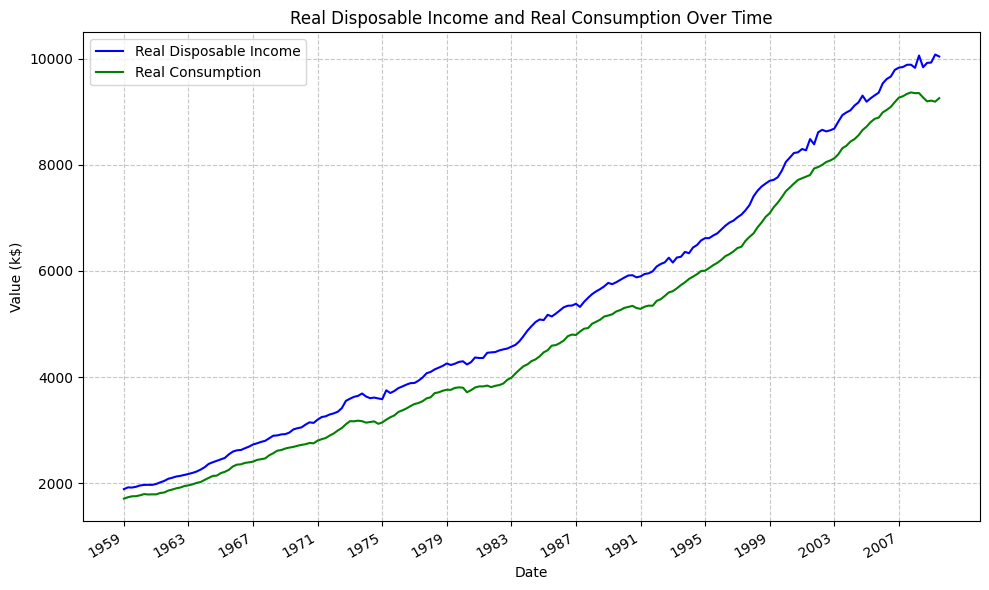

In [ ]:
# 단일 figure와 axis 생성
fig, ax = plt.subplots(figsize=(10, 6))

# 같은 축에 realdpi 플롯
ax.plot(macro_econ_data['realdpi'], label='Real Disposable Income', color='b')

# 같은 축에 realcons 플롯
ax.plot(macro_econ_data['realcons'], label='Real Consumption', color='g')

# 라벨 및 제목 설정
ax.set_xlabel('Date')
ax.set_ylabel('Value (k$)')
ax.set_title('Real Disposable Income and Real Consumption Over Time')

# 격자선 추가
ax.grid(True, linestyle='--', alpha=0.7)

# x축 눈금 설정
ax.set_xticks(np.arange(0, 208, 16))
ax.set_xticklabels(np.arange(1959, 2010, 4))

# 범례 추가
ax.legend(loc='upper left')

# x축 라벨 자동 포맷팅
fig.autofmt_xdate()

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

### ADF 테스트를 활용한 정상성 확인

In [ ]:
print("Running ADF test for realdpi\n")
run_adf_test(macro_econ_data['realdpi'])

print('\n---------------------\n')

print("Running ADF test for realcons\n")
run_adf_test(macro_econ_data['realcons'])

Running ADF test for realdpi

ADF Statistic: 2.986025351954683
p-value: 1.0
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
-> Input series is non-stationary (fail to reject H0).

---------------------

Running ADF test for realcons

ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904
Critical Values:
   1%: -3.4638
   5%: -2.8763
   10%: -2.5746
-> Input series is non-stationary (fail to reject H0).


In [ ]:
print("Running ADF test for realdpi (1st differenced data)\n")
run_adf_test(macro_econ_data['realdpi'].diff()[1:])

print('\n---------------------\n')

print("Running ADF test for realcons (1st differenced data)\n")
run_adf_test(macro_econ_data['realcons'].diff()[1:])

Running ADF test for realdpi (1st differenced data)

ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
-> Input series is stationary (reject H0).

---------------------

Running ADF test for realcons (1st differenced data)

ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571
Critical Values:
   1%: -3.4638
   5%: -2.8763
   10%: -2.5746
-> Input series is stationary (reject H0).


### VAR 모델 찾기

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [ ]:
def optimize_VAR(endog: Union[pd.Series, List]) -> pd.DataFrame:
    """
    주어진 시계열 데이터에 대해 VARMAX 모델을 최적화하고 AIC 값을 기준으로 최적의 차수(p)를 선택하는 함수입니다.

    매개변수:
        endog (Union[pd.Series, List]): 종속 변수 시계열 데이터. 여러 개의 시계열을 포함할 수 있습니다.

    반환값:
        pd.DataFrame: 각 차수(p)와 그에 따른 AIC 값을 포함한 데이터프레임. AIC 값에 따라 오름차순으로 정렬됩니다.

    동작:
        - VARMAX 모델을 다양한 차수(p)에 대해 적합시킨 후, 각 모델의 AIC 값을 계산합니다.
        - AIC 값이 낮을수록 모델이 데이터를 더 잘 설명하는 것으로 간주됩니다.
        - AIC 값에 따라 최적의 p 값을 찾을 수 있도록 결과를 정렬하여 반환합니다.

    예외 처리:
        - 모델 적합 과정에서 오류가 발생할 경우 해당 차수를 건너뜁니다.
    """

    results = []  # 결과를 저장할 리스트

    # 0부터 14까지의 차수(p)에 대해 반복
    for i in tqdm_notebook(range(15)):
        try:
            # VARMAX 모델을 적합 (차수: i)
            model = VARMAX(endog, order=(i, 0)).fit(disp=False)
        except:
            # 모델 적합에 실패하면 해당 차수 건너뜀
            continue

        # AIC 값을 계산하여 저장
        aic = model.aic
        results.append([i, aic])

    # 결과를 데이터프레임으로 변환
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']  # 열 이름 설정

    # AIC 값에 따라 오름차순 정렬
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162] # 약 80% 정도만 사용
test = endog_diff[162:]

In [ ]:
result_df = optimize_VAR(train)
result_df

  0%|          | 0/15 [00:00<?, ?it/s]

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194026
4,2,3130.091668
5,7,3133.398272
6,1,3134.333343
7,8,3137.149014
8,9,3140.367181
9,10,3147.838944


#### Simpler version

In [ ]:
import statsmodels.tsa.api as tsa

# Sample VAR 모델 하나 생성
VAR_model = tsa.VAR(train)

# Order Selection: Information Criteria
ICs = VAR_model.select_order()

print(ICs.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        13.98       14.02   1.178e+06       14.00
1        13.78      13.90*   9.607e+05      13.82*
2        13.76       13.96   9.446e+05       13.84
3       13.72*       14.00  9.056e+05*       13.83
4        13.76       14.12   9.442e+05       13.91
5        13.72       14.17   9.133e+05       13.91
6        13.75       14.27   9.356e+05       13.96
7        13.79       14.40   9.784e+05       14.04
8        13.82       14.51   1.005e+06       14.10
9        13.84       14.61   1.028e+06       14.15
10       13.89       14.74   1.083e+06       14.24
11       13.93       14.86   1.125e+06       14.31
12       13.96       14.97   1.159e+06       14.37
13       14.00       15.09   1.211e+06       14.44
14       14.02       15.19   1.238e+06       14.50
--------------------------------------------------


### Granger 인과 관계

Granger 인과 관계는 두 시계열 $X_t$와 $Y_t$ 간의 인과 관계를 검정하는 통계적 방법입니다.

- **기본 아이디어**:
    - $ X_t $의 과거 값이 $ Y_t $의 미래 값을 예측하는 데 도움을 줄 수 있다면, $ X_t $는 $ Y_t $에 대해 Granger 인과 관계가 있다고 할 수 있습니다.
    - 인과 관계가 있다는 것은 A가 B의 원인이 된다는 의미는 아니며, A가 B의 과거 정보로부터 B의 변동을 예측할 수 있다는 뜻입니다.

- **수학적 정의**:
    - $ Y_t $는 자신의 과거 값으로만 다음과 같이 표현될 수 있습니다:
      $$
      Y_t = \alpha_0 + \sum_{i=1}^{p} \alpha_i Y_{t-i} + \epsilon_t
      $$
    - 만약 $ X_t $의 과거 값이 $ Y_t $의 예측에 추가적인 정보를 제공한다면, 아래와 같은 확장된 모델을 사용할 수 있습니다:
      $$
      Y_t = \beta_0 + \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{i=1}^{q} \gamma_i X_{t-i} + \epsilon_t
      $$
    - 두 모델을 비교하여 $ X_t $의 과거 값이 $ Y_t $를 예측하는 데 유의미한 정보를 제공하는지 검정합니다.

- **Granger 인과 검정**:
    - **귀무 가설 (H0)**: $ X_t $의 과거 값이 $ Y_t $의 미래 값을 예측하는 데 도움이 되지 않는다 (즉, Granger 인과 관계가 없다).
    - **대립 가설 (H1)**: $ X_t $의 과거 값이 $ Y_t $의 미래 값을 예측하는 데 유의미한 정보를 제공한다 (Granger 인과 관계가 있다).

- **결과 해석**:
    - 검정에서 p-value가 0.05보다 작으면, 귀무 가설을 기각하고 Granger 인과 관계가 있다고 결론 내립니다.
    - p-value가 0.05보다 크면, Granger 인과 관계가 없다고 판단합니다.


In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

In [ ]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


두 변수 모두 0.05보다 작은 p-value가 반환됩니다. 따라서 두 변수 간에 상호 Granger  인과관계가 존재한다는 결론을 내릴 수 있습니다.    
이는 VAR 모델의 사용성을 정당화합니다.

### Best model 분석

In [ ]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Sun, 08 Sep 2024   BIC                           3175.559
Time:                             09:33:54   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

In [ ]:
# simpler version 사용시.
optimal_lag = ICs.aic
best_VAR_model = VAR_model.fit(optimal_lag)
print(best_VAR_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Sep, 2024
Time:                     09:33:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.8591
Nobs:                     159.000    HQIC:                   13.6987
Log likelihood:          -1517.54    FPE:                    797340.
AIC:                      13.5889    Det(Omega_mle):         731512.
--------------------------------------------------------------------
Results for equation realdpi
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              19.462598         5.465484            3.561           0.000
L1.realdpi         -0.122995         0.088324           -1.393           0.164
L1.realcons         0.424513         0.120640            3.519    

본 실습에서는 VARMAX를 활용한 모델을 바탕으로 분석을 진행하겠습니다.

### 잔차 분석

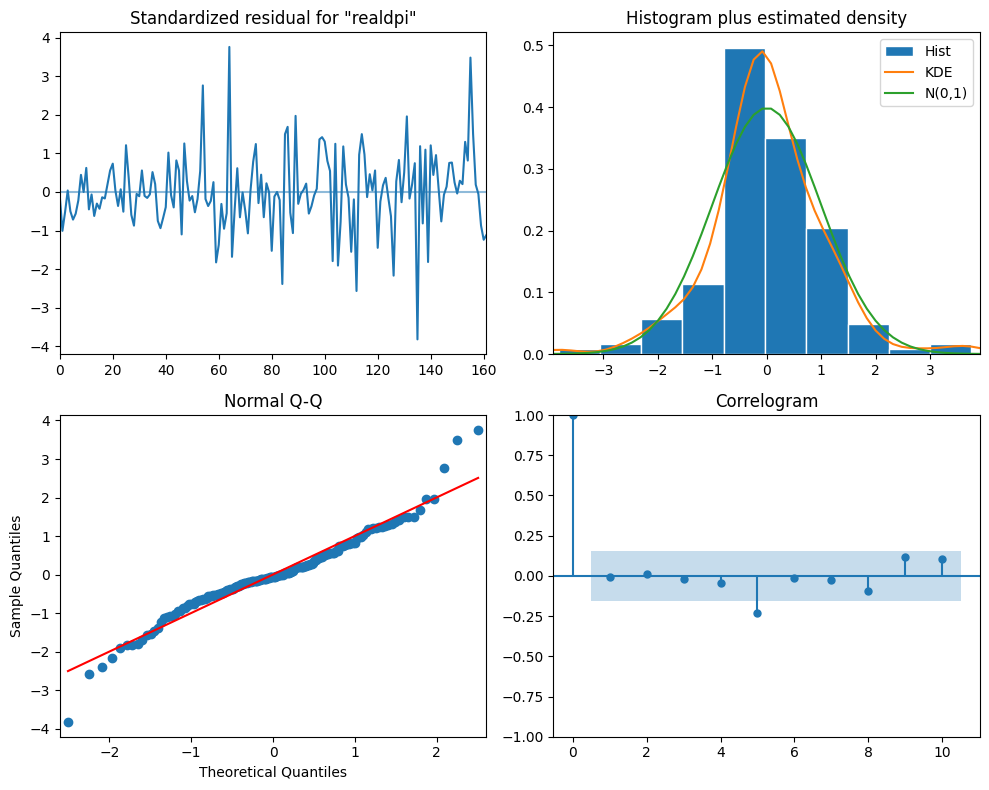

In [ ]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)
plt.tight_layout()
plt.show()

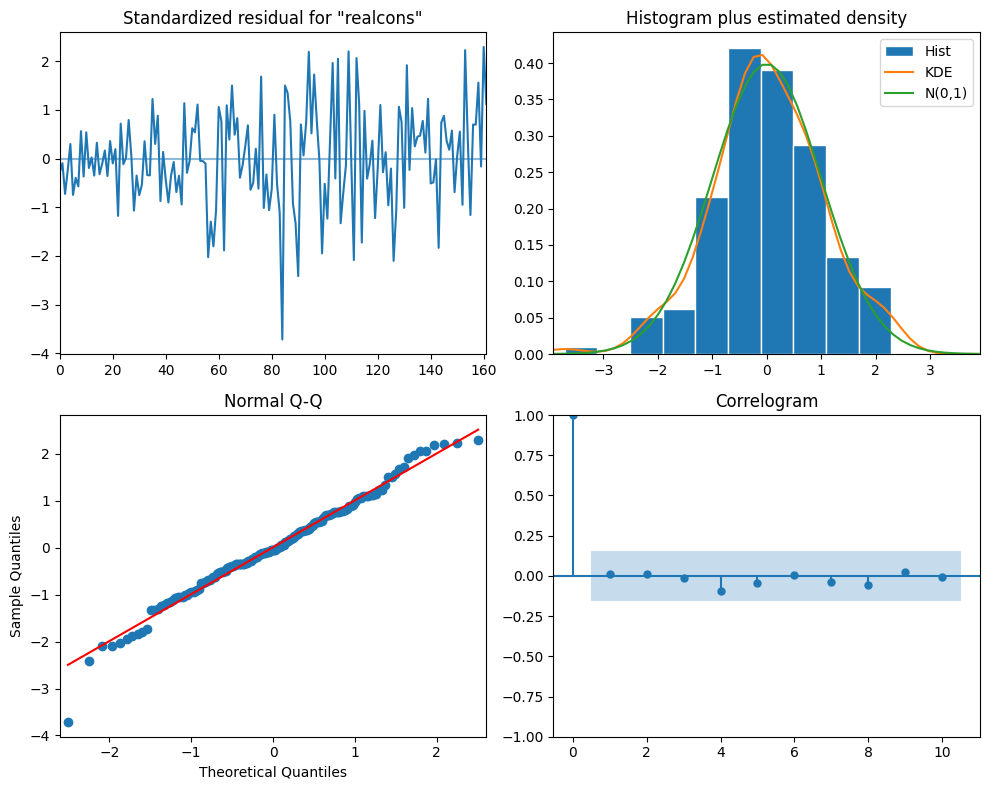

In [ ]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)
plt.tight_layout()
plt.show()

In [ ]:
realgdp_residuals = best_model_fit.resid['realdpi']

acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.011612,0.914186
2,0.029344,0.985435
3,0.075764,0.994578
4,0.377906,0.984246
5,9.142693,0.103506
6,9.165525,0.164481
7,9.270286,0.233829
8,10.811811,0.212592
9,13.318344,0.148723
10,15.287657,0.121921


In [ ]:
realgdp_residuals = best_model_fit.resid['realcons']

acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.023938,0.877042
2,0.068593,0.966285
3,0.068671,0.995311
4,0.235629,0.993582
5,0.377724,0.995921
6,0.787370,0.992408
7,1.015365,0.994577
8,2.150655,0.976041
9,2.437317,0.982522
10,2.442979,0.991681


### 예측 수행

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> List:
    """
    주어진 시계열 데이터에 대해 롤링 방식으로 예측을 수행하는 함수입니다.

    매개변수:
        df (pd.DataFrame): 예측에 사용할 시계열 데이터프레임. 'realdpi'와 'realcons' 두 변수 열이 있어야 함.
        train_len (int): 초기 학습 데이터의 길이 (학습에 사용할 데이터 포인트 수).
        horizon (int): 예측을 위한 기간 (학습 데이터 이후 예측할 총 기간).
        window (int): 한 번에 예측할 기간의 길이.
        method (str): 예측 방법. 'VAR' 또는 'last' 선택 가능.
            - 'VAR': VARMAX 모델을 사용한 예측.
            - 'last': 마지막 값을 반복하여 예측하는 방식.

    반환값:
        List: 예측된 'realdpi'와 'realcons'의 값들이 담긴 리스트들 (두 개의 리스트를 반환).

    동작:
        - 'VAR': VARMAX 모델을 사용하여, 롤링 윈도우 방식으로 매번 예측을 업데이트.
        - 'last': 각 롤링 윈도우에서 'realdpi'와 'realcons'의 마지막 값을 사용하여 예측.
    """

    total_len = train_len + horizon  # 학습 기간과 예측 기간을 더한 총 길이
    end_idx = train_len  # 초기 학습 데이터의 끝 인덱스

    if method == 'VAR':
        # VAR 모델을 사용한 예측
        realdpi_pred_VAR = []  # 'realdpi' 변수에 대한 예측 값 저장
        realcons_pred_VAR = []  # 'realcons' 변수에 대한 예측 값 저장

        # 롤링 윈도우로 예측을 수행 (window 크기만큼 이동하며 예측)
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3, 0))  # VARMAX 모델 적합 (p=3, q=0)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)  # 윈도우 크기만큼 예측

            # 예측된 'realdpi'와 'realcons' 값을 저장
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']

            realdpi_pred_VAR.extend(oos_pred_realdpi)  # 예측 값을 리스트에 추가
            realcons_pred_VAR.extend(oos_pred_realcons)

        return realdpi_pred_VAR, realcons_pred_VAR

    elif method == 'last':
        # 마지막 값을 반복하는 방식으로 예측
        realdpi_pred_last = []  # 'realdpi' 변수에 대한 예측 값 저장
        realcons_pred_last = []  # 'realcons' 변수에 대한 예측 값 저장

        # 롤링 윈도우로 예측을 수행 (window 크기만큼 이동하며 예측)
        for i in range(train_len, total_len, window):

            # 학습 데이터의 마지막 값을 반복하여 예측 값으로 사용
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']

            realdpi_pred_last.extend(realdpi_last for _ in range(window))  # 마지막 값을 윈도우 크기만큼 반복
            realcons_pred_last.extend(realcons_last for _ in range(window))

        return realdpi_pred_last, realcons_pred_last

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

In [ ]:
realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.224539,7354.326623,7716.0,7199.9
164,8053.4,7501.3,7897.189061,7430.258712,7716.0,7199.9
165,8135.9,7571.8,7960.563400,7496.633762,7716.0,7199.9
166,8222.3,7645.9,8014.757620,7556.621097,7716.0,7199.9
167,8234.6,7713.5,8080.700920,7631.009720,8135.9,7571.8
168,8296.5,7744.3,8142.391141,7692.863098,8135.9,7571.8
169,8273.7,7773.5,8200.121950,7753.888435,8135.9,7571.8
170,8484.5,7807.7,8259.363765,7812.564592,8135.9,7571.8
171,8385.5,7930.0,8264.387733,7864.665195,8273.7,7773.5
172,8611.6,7957.3,8320.860098,7895.089936,8273.7,7773.5


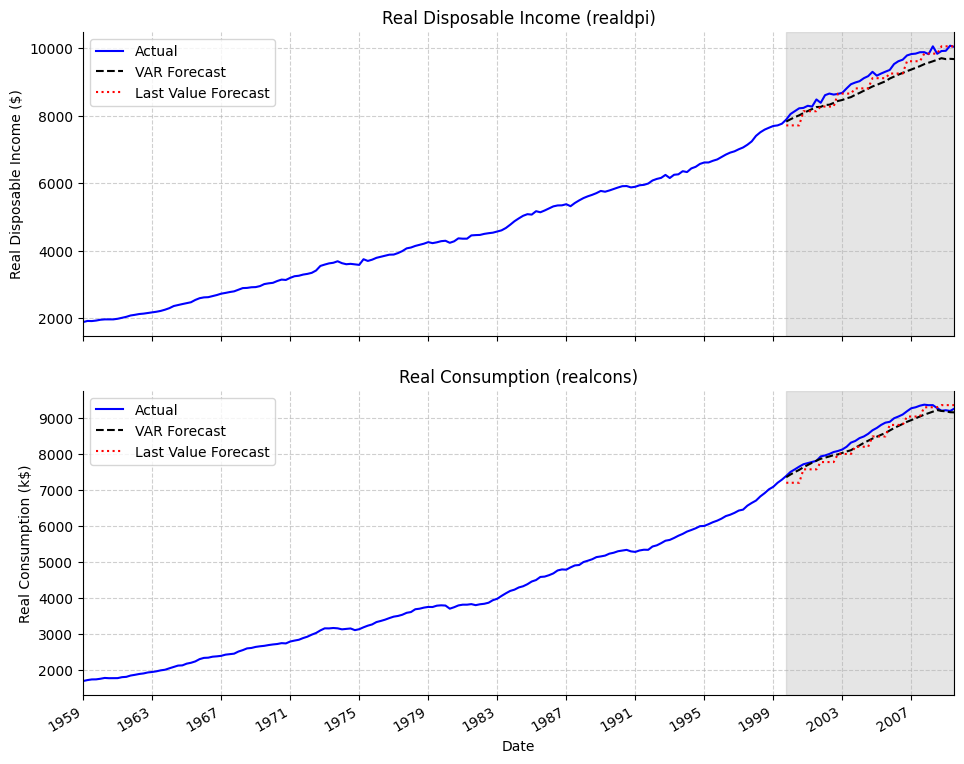

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# realdpi에 대한 그래프
ax1.plot(macro_econ_data['realdpi'], label='Actual', color='blue')  # 실제 값
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR Forecast', color='black')  # VAR 예측 값
ax1.plot(test['realdpi_pred_last'], 'r:', label='Last Value Forecast', color='red')  # 마지막 값 예측

ax1.set_xlabel('Date')
ax1.set_ylabel('Real Disposable Income ($)')
ax1.set_title('Real Disposable Income (realdpi)')
ax1.spines['top'].set_alpha(0)  # 상단 테두리 제거하여 깔끔한 외관
ax1.axvspan(163, 202, color='#808080', alpha=0.2)  # 예측 기간 강조
ax1.set_xlim(100, 202)  # x축 범위 설정
ax1.legend(loc='upper left')  # 범례 위치 설정
ax1.grid(True, linestyle='--', alpha=0.6)  # 격자선 추가

# realcons에 대한 그래프
ax2.plot(macro_econ_data['realcons'], label='Actual', color='blue')  # 실제 값
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR Forecast', color='black')  # VAR 예측 값
ax2.plot(test['realcons_pred_last'], 'r:', label='Last Value Forecast', color='red')  # 마지막 값 예측

ax2.set_xlabel('Date')
ax2.set_ylabel('Real Consumption (k$)')
ax2.set_title('Real Consumption (realcons)')
ax2.spines['top'].set_alpha(0)  # 상단 테두리 제거하여 깔끔한 외관
ax2.axvspan(163, 202, color='#808080', alpha=0.2)  # 예측 기간 강조
ax2.set_xlim(100, 202)  # x축 범위 설정
ax2.legend(loc='upper left')  # 범례 위치 설정
ax2.grid(True, linestyle='--', alpha=0.6)  # 격자선 추가

# 두 그래프에 대한 x축 눈금 및 레이블 설정
ax1.set_xticks(np.arange(0, 208, 16))
ax1.set_xticklabels(np.arange(1959, 2010, 4))
ax2.set_xticks(np.arange(0, 208, 16))
ax2.set_xticklabels(np.arange(1959, 2010, 4))

# 날짜 레이블을 자동으로 회전하여 겹치지 않도록 설정
fig.autofmt_xdate()
plt.tight_layout(pad=2.0)  # 플롯 간격 조정

plt.show()

### MAPE 활용한 모델 성능 평가

In [ ]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

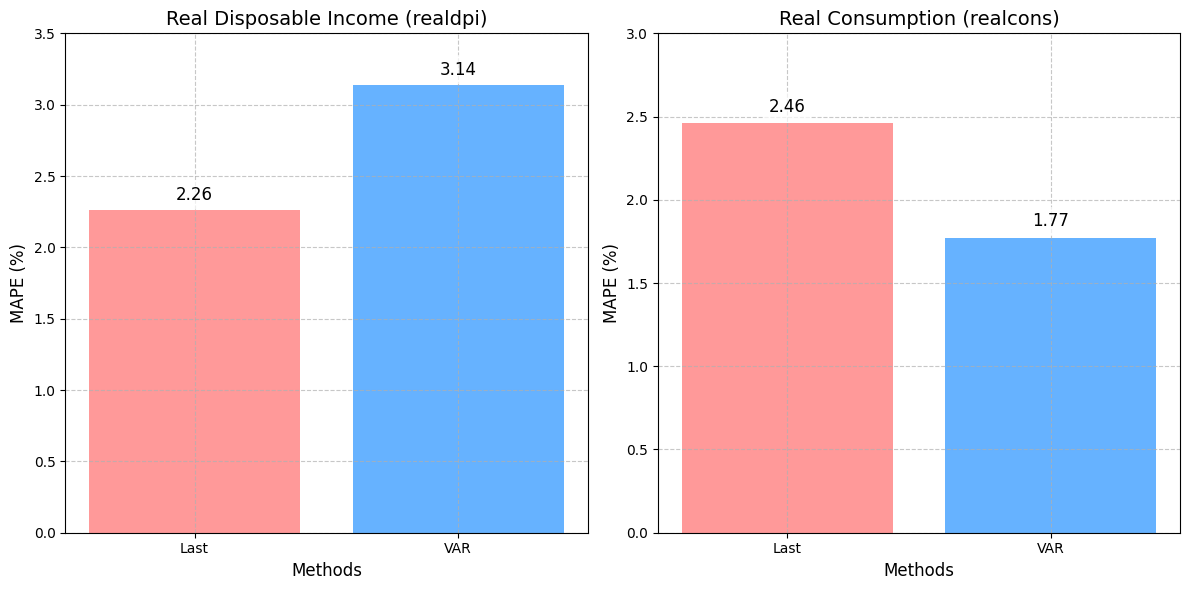

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

x = ['Last', 'VAR']  # 방법(Methods) 라벨
y1 = [mape_realdpi_last, mape_realdpi_VAR]  # realdpi에 대한 MAPE 값
y2 = [mape_realcons_last, mape_realcons_VAR]  # realcons에 대한 MAPE 값

# realdpi에 대한 그래프 (왼쪽 서브플롯)
ax1.bar(x, y1, color=['#FF9999', '#66B2FF'])  # 색상을 다르게 설정하여 구분 용이
ax1.set_xlabel('Methods', fontsize=12)  # x축 라벨 설정
ax1.set_ylabel('MAPE (%)', fontsize=12)  # y축 라벨 설정
ax1.set_title('Real Disposable Income (realdpi)', fontsize=14)  # 제목 설정
ax1.set_ylim(0, 3.5)  # y축 범위 설정
ax1.grid(True, linestyle='--', alpha=0.7)  # 격자선 추가로 가독성 향상

# 막대 위에 값 라벨 추가 (더 나은 위치로 설정)
for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.07, s=str(round(value, 2)), ha='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))  # 흰색 배경으로 라벨 가독성 향상

# realcons에 대한 그래프 (오른쪽 서브플롯)
ax2.bar(x, y2, color=['#FF9999', '#66B2FF'])  # 동일한 색상 체계로 일관성 유지
ax2.set_xlabel('Methods', fontsize=12)  # x축 라벨 설정
ax2.set_ylabel('MAPE (%)', fontsize=12)  # y축 라벨 설정
ax2.set_title('Real Consumption (realcons)', fontsize=14)  # 제목 설정
ax2.set_ylim(0, 3)  # y축 범위 설정
ax2.grid(True, linestyle='--', alpha=0.7)  # 격자선 추가

# 막대 위에 값 라벨 추가
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.07, s=str(round(value, 2)), ha='center', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))  # 흰색 배경으로 라벨 가독성 향상

# 레이아웃 조정으로 플롯 간격 확보
plt.tight_layout()

# 플롯 표시
plt.show()

### 결과 해석


베이스라인 모델보다 **realdpi**의 경우 더 도움이 되지 못한다. 따라서 이를 예측하기 위해서는 다른 모델의 사용 (SARIMAX 등)이 권장된다. 혹은 이동평균 항을 포함하는 모델을 사용하는 것이 하나의 다른 방법이 될 수 있다.